In [91]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from PIL import Image

# For Kaggle Only
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null

import albumentations as album
import segmentation_models_pytorch as smp

## NOTE: Had to train model in Kaggle using it's GPU for faster trainining and downloading GB's of images. Must download the dataset if you want to load and train data locally with CPU.

### Skip to the expiriments section for non training/testing work.

In [ ]:
rootdir = "../input/massachusetts-buildings-dataset/tiff/"
x_train_path = os.path.join(rootdir, 'train')
y_train_path = os.path.join(rootdir, 'train_labels')

x_valid_path = os.path.join(rootdir, 'val')
y_valid_path = os.path.join(rootdir, 'val_labels')

x_test_path = os.path.join(rootdir, 'test')
y_test_path = os.path.join(rootdir, 'test_labels')

In [92]:
classlabeldict = pd.read_csv("label_class_dict.csv")
clasnames = classlabeldict['name'].tolist()
class_rgb_values = classlabeldict[['r','g','b']].values.tolist()

In [93]:
select_class_indices = [clasnames.index(cls.lower()) for cls in clasnames]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [106]:
def displayimages(c, **images):
    n_images = len(images)
    plt.figure(figsize=(16,8))
    n = ""
    for idx,(name,image) in enumerate(images.items()):
        print(name, image.shape)
        n = name
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.savefig(f'pred_{c}.png')
    plt.show()
    
def onehotencode(label,labelvals):
    semanticmap = []
    for color in labelvals:
        equality = np.equal(label,color)
        classmap = np.all(equality,axis=-1)
        semanticmap.append(classmap)
    semanticmap = np.stack(semanticmap, axis=-1)
    return semanticmap

def color_code_segment(image,labelvals):
    colorcodes = np.array(labelvals)
    ccs = colorcodes[image.astype(int)]
    return ccs

def training_augmentations():
    transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf([album.HorizontalFlip(p=1),album.VerticalFlip(p=1),album.RandomRotate90(p=1)],p=0.75)]
    return album.Compose(transform)

def validation_augmentations():   
    transform = [album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)]
    return album.Compose(transform)

def convert_to_tensor(x,**kwargs):
    return x.transpose(2,0,1).astype("float32")

def func_for_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(album.Lambda(image=preprocessing_fn))
    transform.append(album.Lambda(image=convert_to_tensor,mask=convert_to_tensor))
    return album.Compose(transform)

def crop_image(image, target_image_dims=[1500,1500,3]):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,]


In [95]:
class DatasetCreation(torch.utils.data.Dataset):
    def __init__(self,images_dir,masks_dir, class_rgb_vals=None, augment=None,preprocess=None):
        self.imagespath = [os.path.join(images_dir,imageid) for imageid in sorted(os.listdir(images_dir))]
        self.maskspath = [os.path.join(masks_dir,maskid) for maskid in sorted(os.listdir(masks_dir))]
        self.class_rgb_vals = class_rgb_vals
        self.augment = augment
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.imagespath)
        
    def __getitem__(self,i):
        image = cv2.cvtColor(cv2.imread(self.imagespath[i]),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.maskspath[i]),cv2.COLOR_BGR2RGB)
        mask = onehotencode(mask,self.class_rgb_vals).astype("float")
        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']
        if self.preprocess:
            sample = self.preprocess(image=image,mask=mask)
            image,mask = sample['image'],sample['mask']
        return image,mask

class ExperimentDataset(torch.utils.data.Dataset):
    def __init__(self,images_dir,augment=None,preprocess=None):
        self.imagespath = [os.path.join(images_dir,imageid) for imageid in sorted(os.listdir(images_dir))]
        self.augment = augment
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.imagespath)
        
    def __getitem__(self,i):
        image = cv2.cvtColor(cv2.imread(self.imagespath[i]),cv2.COLOR_BGR2RGB)
        if self.augment:
            sample = self.augment(image=image)
            image= sample['image']
        if self.preprocess:
            sample = self.preprocess(image=image)
            image = sample['image']
        return image

In [ ]:
dataset = DatasetCreation(x_train_path, y_train_path, class_rgb_vals=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image,mask = dataset[random_idx]

In [96]:
encoder = "resnet34"
encoder_weights = "imagenet"
activation = "sigmoid"

In [ ]:
model = smp.UnetPlusPlus(encoder_name=encoder,encoder_weights=encoder_weights, classes=len(clasnames),activation="sigmoid")

In [97]:
preprocess_func = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

In [ ]:
traindata = DatasetCreation(x_train_dir,y_train_dir,augment = training_augmentations(),
                           preprocess = func_for_preprocessing(preprocess_func),
                           class_rgb_vals = select_class_rgb_values)

validdata = DatasetCreation(x_valid_dir,y_valid_dir,augment = validation_augmentations(),
                           preprocess = func_for_preprocessing(preprocess_func),
                           class_rgb_vals = select_class_rgb_values)

trainloader = DataLoader(traindata,batch_size=16,shuffle=True)
validloader = DataLoader(validdata,batch_size=1,shuffle=False)

trainmodel = True
epochs = 100

loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
trainepoch = smp.utils.train.TrainEpoch(model,loss=loss,optimizer=optimizer,metrics=metrics,device=device,verbose=True)
validepoch = smp.utils.train.ValidEpoch(model,loss=loss,metrics=metrics,device=device,verbose=True)

In [ ]:
if trainmodel:
    best_iou_score = 0.0 
    train_log, valid_log = [], []
    for i in range(0,epochs):
        print('\nEpoch: {}'.format(i))
        tlog = trainepoch.run(trainloader)
        vlog = validepoch.run(validloader)
        train_log.append(tlog)
        valid_log.append(vlog)
        if best_iou_score < vlog['iou_score']:
            best_iou_score = vlog['iou_score']
            torch.save(model, './best_model.pth')
    print("Model Training completed successfully !")

In [ ]:
if os.path.exists('unetpp/best_model.pth'):
    best_model = torch.load('unetpp/best_model.pth', map_location=device)
    print('Loaded Unetpp model')

In [ ]:
testdata = DatasetCreation(x_test_dir,y_test_dir,augment = validation_augmentations(),
                           preprocess = func_for_preprocessing(preprocess_func),
                           class_rgb_vals = select_class_rgb_values)

testloader = DataLoader(testdata)

testdata_without_preprocess = DatasetCreation(x_test_dir,y_test_dir,augment = validation_augmentations(),
                           class_rgb_vals = select_class_rgb_values)

random_idx = random.randint(0, len(testdata_without_preprocess)-1)
image, mask = testdata_without_preprocess[random_idx]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(testdata)):
    image, gt_mask = testdata[idx]
    image_vis = crop_image(testdata_without_preprocess[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,clasnames.index('building')]
    pred_mask = crop_image(color_code_segment(np.argmax(pred_mask,axis=-1), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(color_code_segment(np.argmax(gt_mask,axis=-1), select_class_rgb_values))
        
    displayimages(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask)

In [ ]:
testepoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

valid_log = testepoch.run(testloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_log['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_log['dice_loss']:.4f}")

In [ ]:
# train_logs = pd.DataFrame(train_log)
# valid_logs = pd.DataFrame(valid_log)
# train_logs.T

In [ ]:
# train_logs.to_csv("trainlogs.csv")
# valid_logs.to_csv("validlogs.csv")

## Below is pulled from pre-trained model

In [63]:
train_logs = pd.read_csv('trainlogs.csv')
valid_logs = pd.read_csv('validlogs.csv')

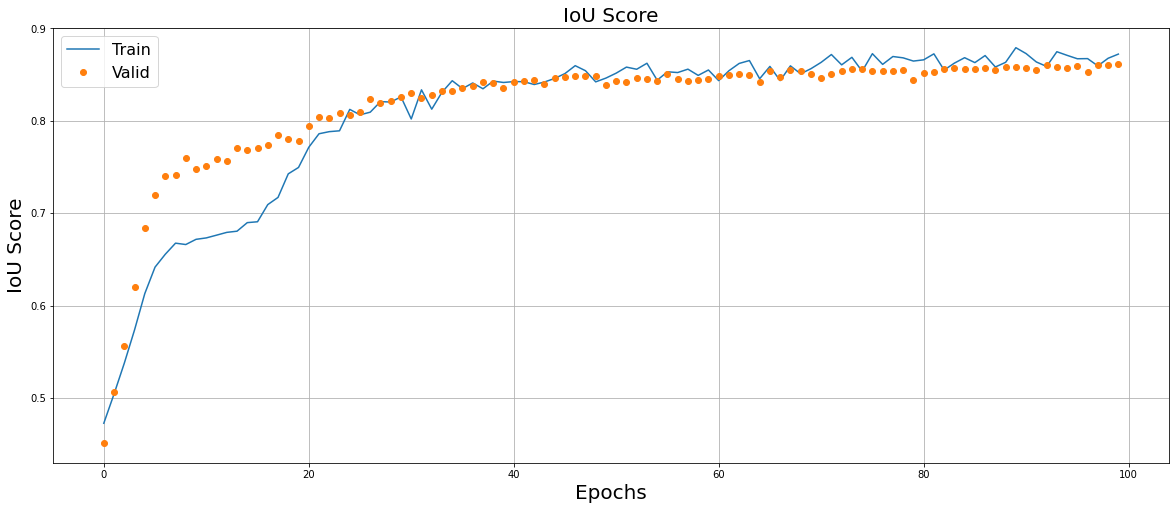

In [64]:
plt.figure(figsize=(20,8))
plt.plot(train_logs.index.tolist(), train_logs.iou_score.tolist(),label = 'Train')
plt.plot(valid_logs.index.tolist(), valid_logs.iou_score.tolist(),'o', label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('sample_predictions/iou_score_plot.png')
plt.show()

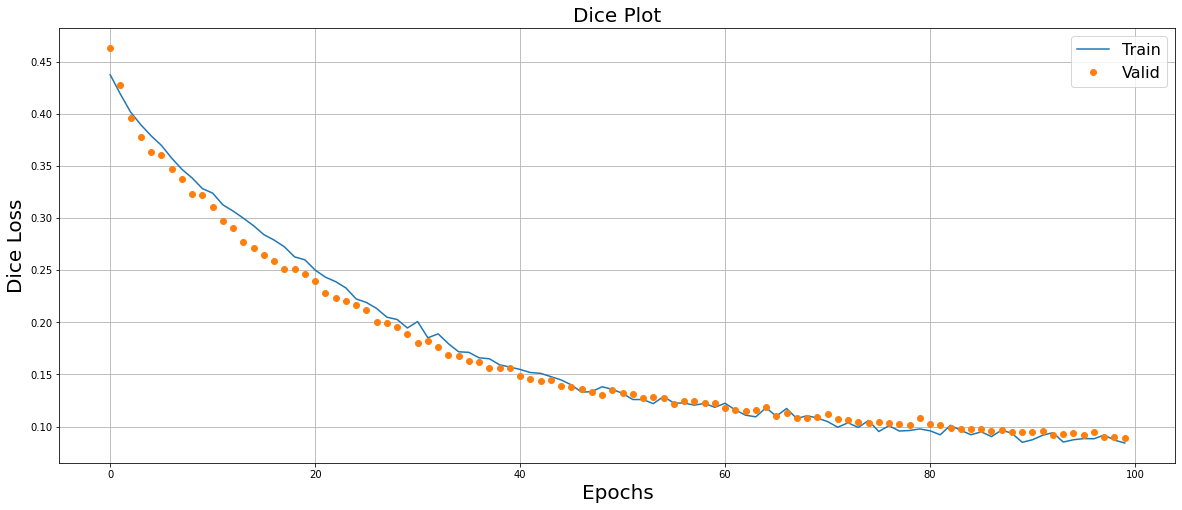

In [65]:
plt.figure(figsize=(20,8))
plt.plot(train_logs.index.tolist(), train_logs.dice_loss.tolist(),label = 'Train')
plt.plot(valid_logs.index.tolist(), valid_logs.dice_loss.tolist(),'o',label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('sample_predictions/dice_loss_plot.png')
plt.show()

## Experiment with homes with pools and patios

In [110]:
exp_data = ExperimentDataset("experiment_images", augment = validation_augmentations(),
                           preprocess = func_for_preprocessing(preprocess_func))

exp_without_preprocess = ExperimentDataset("experiment_images", augment = validation_augmentations())

# images_names = os.listdir('experiment_images')

# exp_without_preprocess = ExperimentDataset("experiment_images")


In [100]:
if os.path.exists('unetpp/best_model.pth'):
    best_model = torch.load('unetpp/best_model.pth', map_location=device)
    print('Loaded Unetpp model')

Loaded Unet model


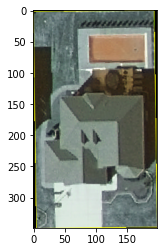

In [38]:
# img = Image.open('experiment_images/08-07-352-002.png')
# img = img.resize((1536, 1536), Image.ANTIALIAS)
# img.save('resized_image.png')

original_image (1536, 1536, 3)
predicted_mask (1500, 1500, 3)


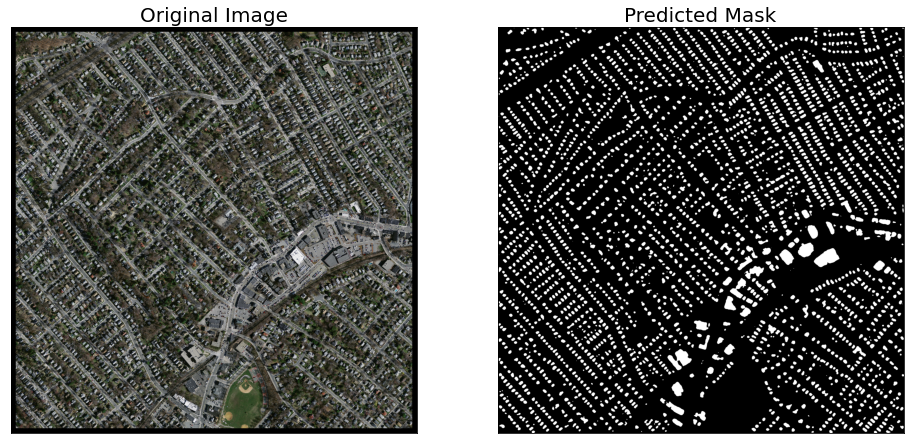

original_image (1536, 1536, 3)
predicted_mask (1500, 1500, 3)


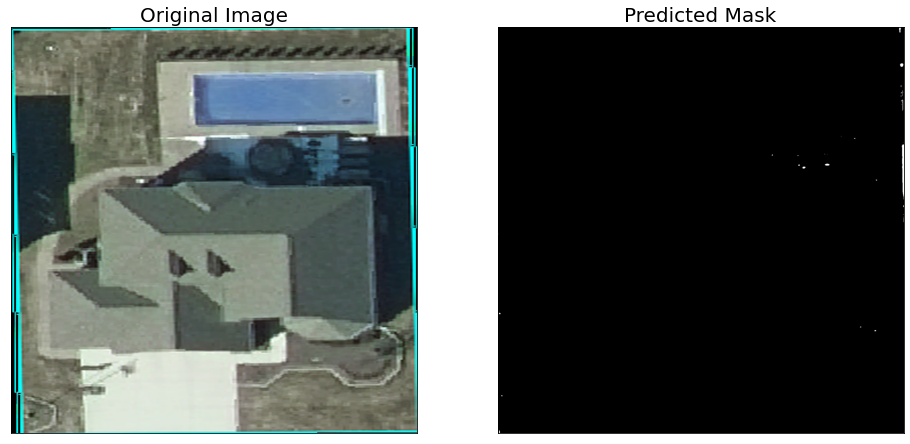

original_image (1536, 1536, 3)
predicted_mask (1500, 1500, 3)


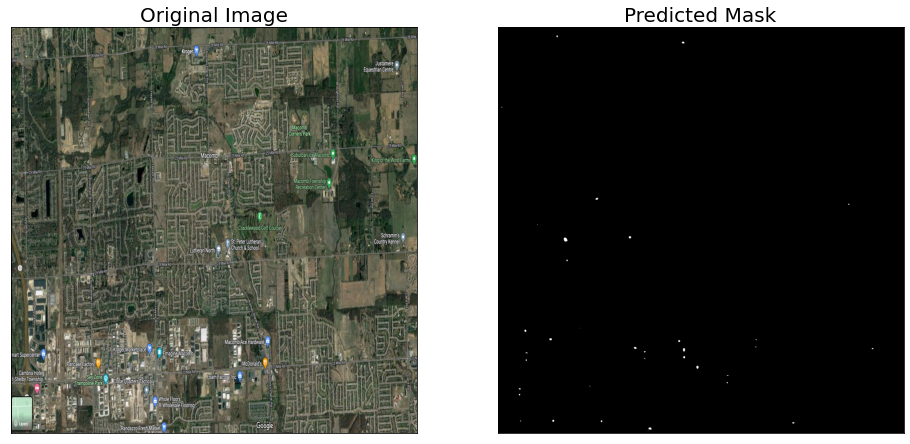

original_image (1536, 1536, 3)
predicted_mask (1500, 1500, 3)


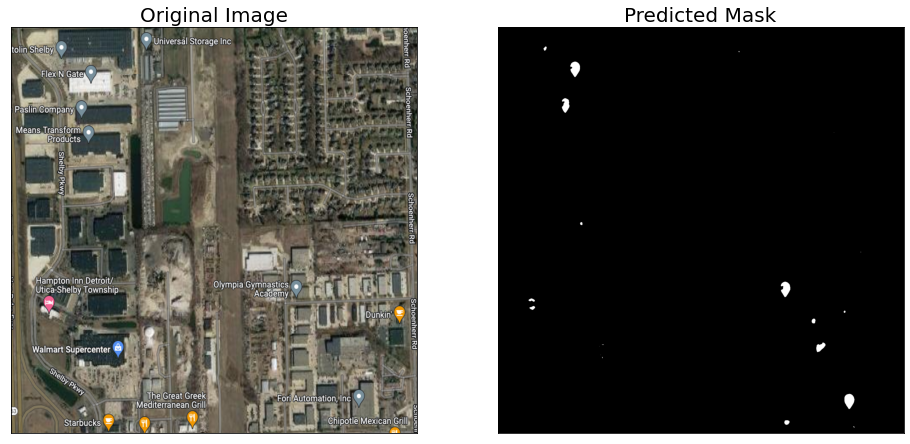

original_image (1536, 1536, 3)
predicted_mask (1500, 1500, 3)


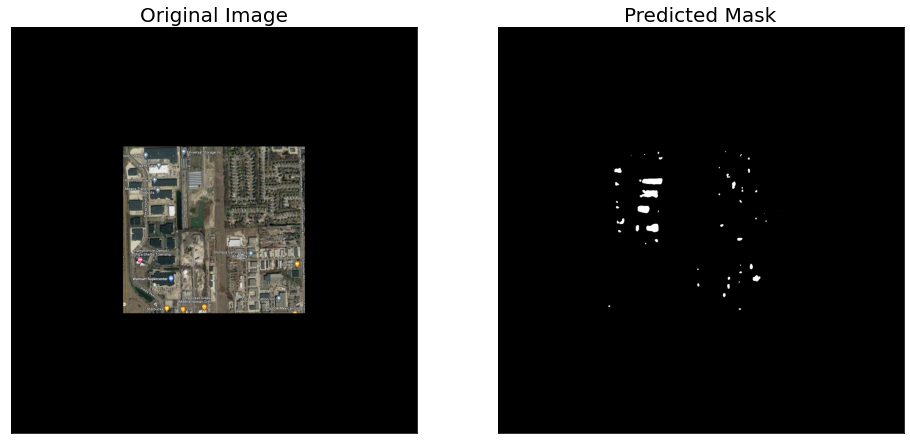

In [111]:
c = 0
for idx in range(len(exp_data)):
    image = exp_data[idx]
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    # pred_building_heatmap = pred_mask[:,:,clasnames.index('building')]
    pred_mask = crop_image(color_code_segment(np.argmax(pred_mask,axis=-1), select_class_rgb_values))
    displayimages(
        c,
        original_image = exp_without_preprocess[idx],
        predicted_mask = pred_mask)
    c += 1
    